In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
import os
os.chdir('C:\\Users\\10335\\Downloads\\Default_Prediction_Research-master')
os.listdir(".")

['.ipynb_checkpoints',
 'data.csv',
 'Ensembling_Voting_Classifier.ipynb',
 'Keras_implementation.ipynb']

# Loading of data

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head(5)

,Company.Name,PBDITAM,PATMARG,CASHPRFM,NPM,ROE,ROCE,RONW,TNW,CR,...,CL/NW,SALES,Size,MKTCAP,LTD,DEBTORDAYS,CREDITORDAYS,NWCCYCLE,YEAR,Target
0,Adani Enterprises Ltd.,6.28,3.83,3.84,2.42,27.87,7.96,17.34,4769.1,1.41,...,166.22,30062.4,20379.8,4798.62,15744.9,107.99,71.89,115.46,1993.0,0
1,Adani Enterprises Ltd.,5.90,1.14,2.29,1.17,6.72,3.23,6.87,4961.1,1.27,...,166.93,28124.4,22697.2,3568.92,13932.8,128.83,87.05,100.23,1993.0,0
2,Adani Enterprises Ltd.,6.92,1.86,3.13,1.84,10.31,5.38,10.22,5406.8,1.44,...,123.93,27617.3,22953.2,2710.18,14608.1,131.37,80.62,64.66,1993.0,0
3,Adani Enterprises Ltd.,3.32,1.72,1.74,1.65,21.52,12.18,20.58,6128.0,1.56,...,147.38,70686.9,30111.2,8859.20,41529.5,55.57,36.29,30.67,1993.0,0
4,Adani Enterprises Ltd.,2.57,0.79,0.81,0.73,16.83,8.02,15.51,6744.3,1.29,...,175.90,135135.3,50923.8,13481.63,46214.6,44.42,35.88,16.94,1993.0,0


In [5]:
df.shape

(727, 25)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 25 columns):
Company.Name    727 non-null object
PBDITAM         727 non-null float64
PATMARG         727 non-null float64
CASHPRFM        727 non-null float64
NPM             727 non-null float64
ROE             727 non-null float64
ROCE            727 non-null float64
RONW            727 non-null float64
TNW             727 non-null float64
CR              727 non-null float64
QR              727 non-null float64
DE              727 non-null float64
EXP%SALES       727 non-null float64
FOREXEARNGS     727 non-null float64
DR              727 non-null float64
CL/NW           727 non-null float64
SALES           727 non-null float64
Size            727 non-null float64
MKTCAP          727 non-null float64
LTD             727 non-null float64
DEBTORDAYS      727 non-null float64
CREDITORDAYS    727 non-null float64
NWCCYCLE        727 non-null float64
YEAR            727 non-null float64
Target  

In [7]:
del df['Company.Name']

# Outlier Detection

In [8]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

In [9]:
df.columns

Index(['PROMSHR', 'PROMPLEDG', 'FORPROM', 'Market.Capitalisation', 'EPS',
       'P.E', 'P.B', 'BVS', 'Beta', 'TA', 'Alpha', 'PBDITAINC', 'PBTINC',
       'PATINC', 'CASHPRFINC', 'PBDITAMARG', 'OPMARG', 'OPRFINCOS', 'PBPTEQ',
       'ROE', 'RONW', 'CASHROE', 'PBPTCE', 'ROCE', 'PATCE', 'PBPTTA', 'ROTA',
       'PATTA', 'QR', 'CR', 'DE', 'CASHCL', 'CASHCOS', 'TURNOVER', 'NAT',
       'PVT', 'FORGN', 'OTHERS', 'Target'],
      dtype='object')

In [10]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(df,2,['PROMSHR', 'PROMPLEDG', 'FORPROM', 'Market.Capitalisation', 'EPS',
       'P.E', 'P.B', 'BVS', 'Beta', 'TA', 'Alpha', 'PBDITAINC', 'PBTINC',
       'PATINC', 'CASHPRFINC', 'PBDITAMARG', 'OPMARG', 'OPRFINCOS', 'PBPTEQ',
       'ROE', 'RONW', 'CASHROE', 'PBPTCE', 'ROCE', 'PATCE', 'PBPTTA', 'ROTA',
       'PATTA', 'QR', 'CR', 'DE', 'CASHCL', 'CASHCOS', 'TURNOVER'])

In [14]:
df.loc[Outliers_to_drop].shape

(154, 39)

In [16]:
# Drop outliers
#df = df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [8]:
df['YEAR'] = df['YEAR'].astype('category')

In [11]:
age_bins = [0,1960,1970,1980,1990,2000,2017]
age_labels = ['1','2','3','4','5','6']
df['YEAR'] = pd.cut(df['YEAR'], age_bins, labels = age_labels,right=True,include_lowest = True)

In [12]:
df['Age_1'] = df['YEAR'].map(lambda s:1 if s == '1' else 0)
df['Age_2'] = df['YEAR'].map(lambda s:1 if s == '2' else 0)
df['Age_3'] = df['YEAR'].map(lambda s:1 if s == '3' else 0)
df['Age_4'] = df['YEAR'].map(lambda s:1 if s == '4' else 0)
df['Age_5'] = df['YEAR'].map(lambda s:1 if s == '5' else 0)
df['Age_6'] = df['YEAR'].map(lambda s:1 if s == '6' else 0)
#del df['YEAR']
df = df.drop(labels = ['YEAR'],axis = 1)

In [15]:
df.columns

Index(['PBDITAM', 'PATMARG', 'CASHPRFM', 'NPM', 'ROE', 'ROCE', 'RONW', 'TNW',
       'CR', 'QR', 'DE', 'EXP%SALES', 'FOREXEARNGS', 'DR', 'CL/NW', 'SALES',
       'Size', 'MKTCAP', 'LTD', 'DEBTORDAYS', 'CREDITORDAYS', 'NWCCYCLE',
       'Target', 'Age_1', 'Age_2', 'Age_3', 'Age_4', 'Age_5', 'Age_6'],
      dtype='object')

### Preprocessing

In [17]:
pr_sc = ['PBDITAM', 'PATMARG', 'CASHPRFM', 'NPM', 'ROE', 'ROCE', 'RONW', 'TNW',
       'CR', 'QR', 'DE', 'EXP%SALES', 'FOREXEARNGS', 'DR', 'CL/NW', 'SALES',
       'Size', 'MKTCAP', 'LTD', 'DEBTORDAYS', 'CREDITORDAYS', 'NWCCYCLE']

In [18]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(df[pr_sc])
df[pr_sc] = std_scale.transform(df[pr_sc])

In [19]:
df.head(5)

,PBDITAM,PATMARG,CASHPRFM,NPM,ROE,ROCE,RONW,TNW,CR,QR,...,DEBTORDAYS,CREDITORDAYS,NWCCYCLE,Target,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
0,-0.048585,0.038829,0.011679,0.032825,0.304731,-0.206990,-0.012492,-0.452417,-0.061110,0.110255,...,0.055505,-0.190188,0.027540,0,0,0,0,0,1,0
1,-0.051042,0.031549,0.005198,0.028310,-0.125756,-0.207430,-0.114486,-0.447854,-0.104835,0.042998,...,0.093540,-0.189161,0.025805,0,0,0,0,0,1,0
2,-0.044447,0.033497,0.008711,0.030730,-0.052685,-0.207230,-0.081852,-0.437260,-0.051741,0.151644,...,0.098176,-0.189597,0.021751,0,0,0,0,0,1,0
3,-0.067723,0.033118,0.002899,0.030044,0.175483,-0.206597,0.019070,-0.420117,-0.014263,0.146471,...,-0.040169,-0.192599,0.017878,0,0,0,0,0,1,0
4,-0.072572,0.030601,-0.000990,0.026721,0.080023,-0.206984,-0.030319,-0.405468,-0.098588,0.053345,...,-0.060519,-0.192627,0.016313,0,0,0,0,0,1,0


In [ ]:
df.to_csv("after_preprocessing.csv",index=False)

### Modelling

In [20]:
train = df

In [21]:
X_train = train.drop(labels = ["Target"],axis = 1)
Y_train = train["Target"]

In [22]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

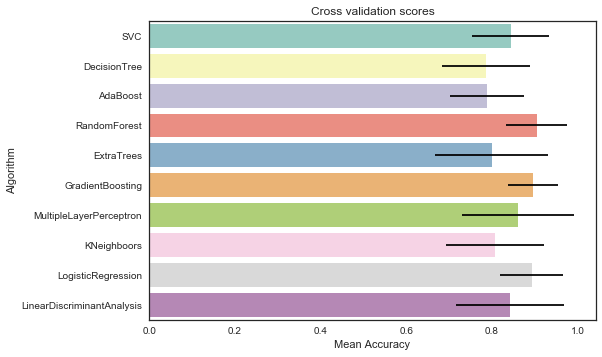

In [23]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [24]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 1008 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   17.6s finished


In [25]:
gsadaDTC.best_score_

0.85144429160935353

In [26]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  3.4min finished


0.86657496561210456

In [30]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  5.5min finished


0.92297111416781297

In [27]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.7min finished


0.93535075653370015

In [28]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   34.8s finished


0.88720770288858319

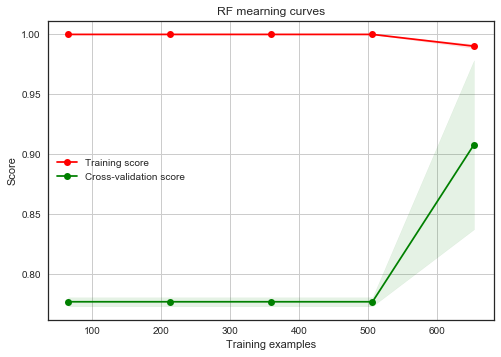

In [35]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)


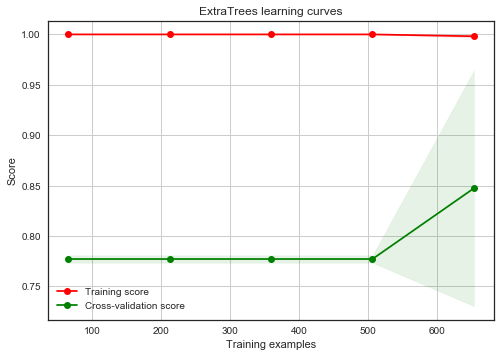

In [36]:
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)

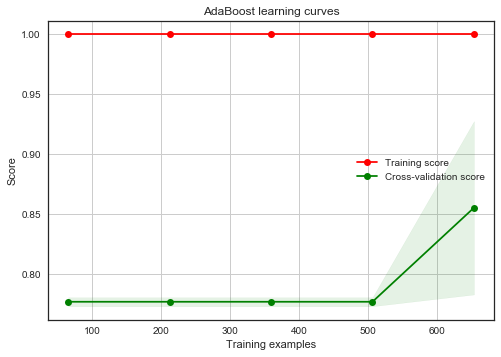

In [37]:

g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)


In [42]:
#g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
#g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)

In [43]:
import numpy as np
np.unique(Y_train)

array([0, 1], dtype=int64)

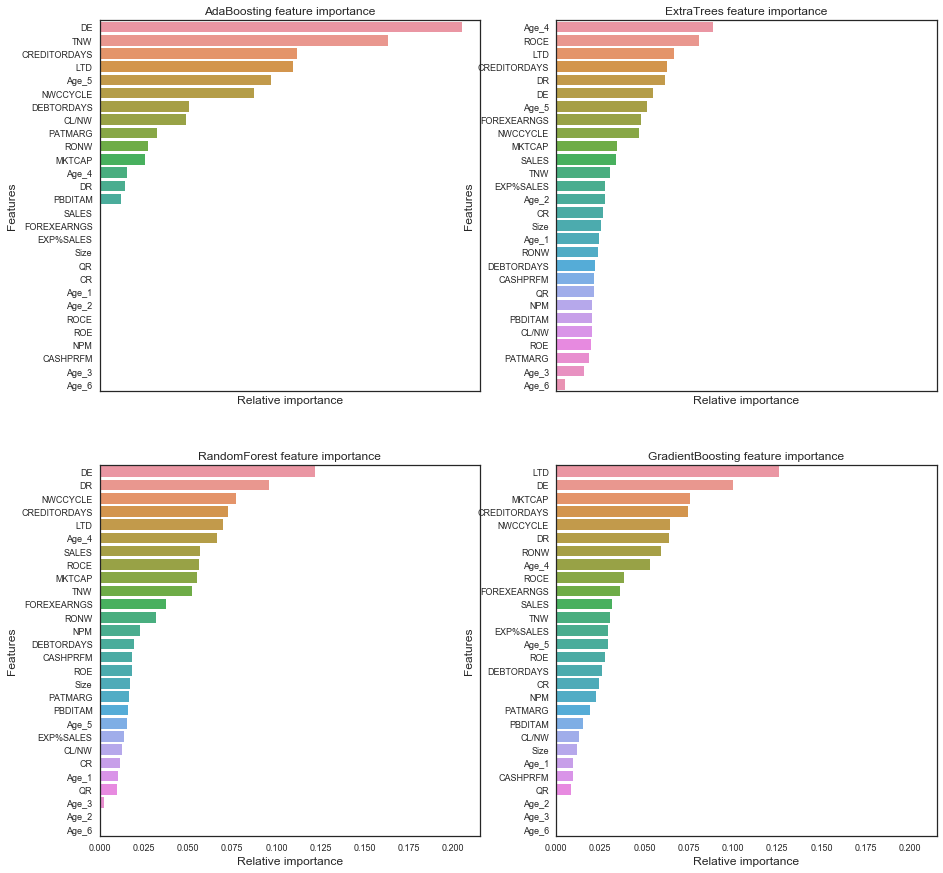

In [44]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [32]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

NameError: name 'test' is not defined

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)